# TSA - NFL Project (Group 1)
## Create ARIMA models for all time series we have
- Authors: Jay Chiehen LIAO (jay-chiehen.liao@rennes-sb.com)
    - Based on Chin-Ching YANG's expolation on several time series
- Create on 28 Nov 2021
- Revised on 29-30 Nov, 2-5 Dec 2021

## Import all required packages and the dataset

In [110]:
from tqdm import tqdm              # progress bar
from sklearn.metrics import *
import pickle, time, sys           # data importing, time calculation, system operation
import numpy as np                 # linear algebra
import pandas as pd                # data frame
import statsmodels.api as sm       # statistical models 
import seaborn as sns              # data visualiation
import matplotlib.pyplot as plt     
%matplotlib inline

# TSA
from scipy import signal
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [4]:
t0 = time.time()
with open('./data/tracking_small.pkl', 'rb') as f:
    tracking_small = pickle.load(f)
print('Time cost: %8.8f s' % (time.time() - t0))

Time cost: 0.06295204 s


In [5]:
tracking_small.keys()

dict_keys([2018, 2019, 2020])

`tracking_small` is a dictionary with 3 pandas data frames.

## Data Overview

- `time`: Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)
- `x`: Player position along the long axis of the field, 0 - 120 yards. See Figure 1 below. (numeric)
- `y`: Player position along the short axis of the field, 0 - 53.3 yards. See Figure 1 below. (numeric)
- `s`: Speed in yards/second (numeric)
- `a`: Speed in yards/second^2 (numeric)
- `dis`: Distance traveled from prior time point, in yards (numeric)
- `o`: Player orientation (deg), 0 - 360 degrees (numeric)
- `dir`: Angle of player motion (deg), 0 - 360 degrees (numeric)

### See the dimenstion of each dataset before and after removing rows without player ID (`nflId`)

In [6]:
for year, data in tracking_small.items():
    original_shape = data.shape
    no_missing = sum(pd.isnull(data['nflId']))
    data_new = data[-pd.isnull(data['nflId'])].copy()
    
    S1 = data_new['nflId'].copy()
    S2 = data_new['playId'].copy()
    S1 = S1.astype(str)
    S2 = S2.astype(str)
    S3 = S1 + S2

    no_unique_players = len(S1.unique())
    no_unique_plays = len(S2.unique())
    no_unique_TS = len(S3.unique())
    
    data_new['tsId'] = S3 
    
    print(year, original_shape, no_missing, data_new.shape, no_unique_players, no_unique_plays, no_unique_TS)
    tracking_small[year] = data_new

2018 (45678, 19) 1986 (43692, 20) 66 27 594
2019 (37858, 19) 1646 (36212, 20) 55 19 418
2020 (50462, 19) 2194 (48268, 20) 70 29 638


We have 594, 418, and 638 time series for data in three years.

In [14]:
df0 = df_single
df0.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,date,tsId
9334965,2018-10-07T17:02:34.900,60.29,28.92,0.06,0.16,0.00,158.45,99.08,None,42555.0,Anthony Chickillo,56.0,OLB,home,1,2018100707,37,right,2018-10-07,42555.037
9334966,2018-10-07T17:02:35.000,60.30,28.91,0.09,0.22,0.01,159.48,129.26,None,42555.0,Anthony Chickillo,56.0,OLB,home,2,2018100707,37,right,2018-10-07,42555.037
9334967,2018-10-07T17:02:35.100,60.31,28.90,0.16,0.37,0.01,160.63,140.27,None,42555.0,Anthony Chickillo,56.0,OLB,home,3,2018100707,37,right,2018-10-07,42555.037
9334968,2018-10-07T17:02:35.200,60.32,28.89,0.20,0.49,0.02,163.30,146.71,None,42555.0,Anthony Chickillo,56.0,OLB,home,4,2018100707,37,right,2018-10-07,42555.037
9334969,2018-10-07T17:02:35.300,60.33,28.87,0.23,0.40,0.02,164.74,152.39,None,42555.0,Anthony Chickillo,56.0,OLB,home,5,2018100707,37,right,2018-10-07,42555.037


## Visualize the Data

We drew figures of "time and speed" for 10 players. We also tried to see if time series of their speeds are seasonal

In [19]:
# adjust the unit of time.

def time_transformation(S):
    S = S.split('T')[-1]
    times_non_ms = S.split('.')[0].split(':')
    ms = int(S.split('.')[-1])
    h = int(times_non_ms[0])
    m = int(times_non_ms[1])
    s = int(times_non_ms[2])
    return h*60*60 + m*60 + s + ms/1000

# test the function
print(time_transformation('2018-10-07T17:02:34.900'))
print(time_transformation('2018-10-07T17:02:35.000'))

61354.9
61355.0


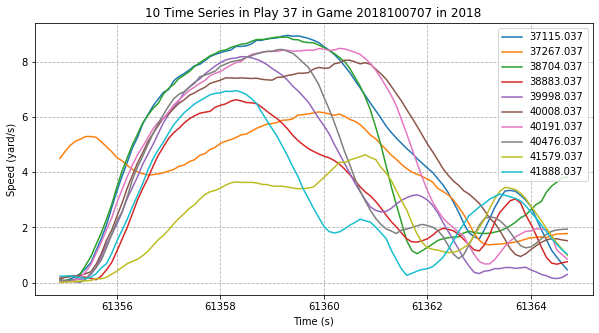

In [83]:
year = 2018
plt.figure(figsize=(10, 5))
for i in range(10):
    tsId = tracking_small[year].tsId.unique()[i]
    df1 = tracking_small[year][tracking_small[year].tsId == tsId].loc[:,['time', 's']]
    x = df1['time'].apply(time_transformation)
    plt.plot(x, df1.s, label=tsId)

plt.legend()
plt.title('10 Time Series in Play 37 in Game 2018100707 in 2018')
plt.xlabel('Time (s)')
plt.ylabel('Speed (yard/s)')
plt.grid(linestyle='--')

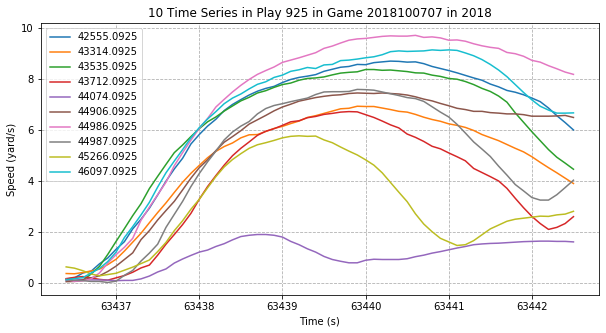

In [84]:
year = 2018
plt.figure(figsize=(10, 5))
for i in range(120, 130):
    tsId = tracking_small[year].tsId.unique()[i]
    df1 = tracking_small[year][tracking_small[year].tsId == tsId].loc[:,['time', 's']]
    x = df1['time'].apply(time_transformation)
    plt.plot(x, df1.s, label=tsId)

plt.legend()
plt.title('10 Time Series in Play 925 in Game 2018100707 in 2018')
plt.xlabel('Time (s)')
plt.ylabel('Speed (yard/s)')
plt.grid(linestyle='--')

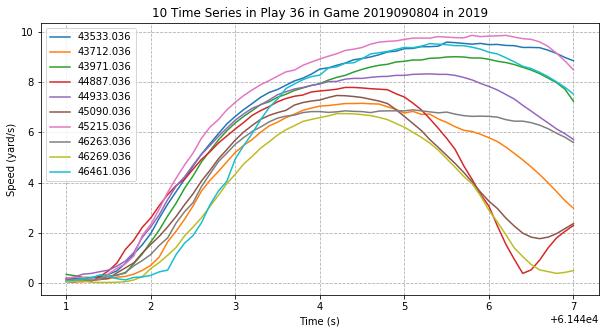

In [79]:
year = 2019
plt.figure(figsize=(10, 5))
for i in range(10, 20):
    tsId = tracking_small[year].tsId.unique()[i]
    df1 = tracking_small[year][tracking_small[year].tsId == tsId].loc[:,['time', 's']]
    x = df1['time'].apply(time_transformation)
    plt.plot(x, df1.s, label=tsId)

plt.legend()
plt.title('10 Time Series in Play 36 in Game 2019090804 in 2019')
plt.xlabel('Time (s)')
plt.ylabel('Speed (yard/s)')
plt.grid(linestyle='--')

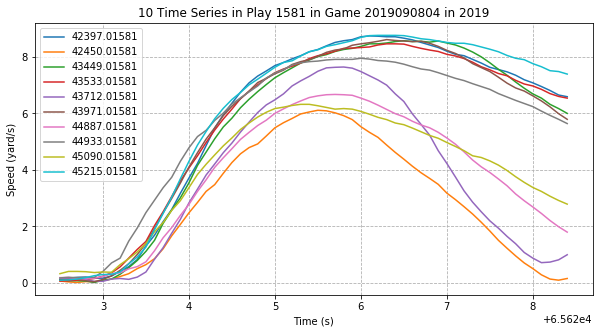

In [90]:
year = 2019
plt.figure(figsize=(10, 5))
for i in range(160, 170):
    tsId = tracking_small[year].tsId.unique()[i]
    df1 = tracking_small[year][tracking_small[year].tsId == tsId].loc[:,['time', 's']]
    x = df1['time'].apply(time_transformation)
    plt.plot(x, df1.s, label=tsId)

plt.legend()
plt.title('10 Time Series in Play 1581 in Game 2019090804 in 2019')
plt.xlabel('Time (s)')
plt.ylabel('Speed (yard/s)')
plt.grid(linestyle='--')

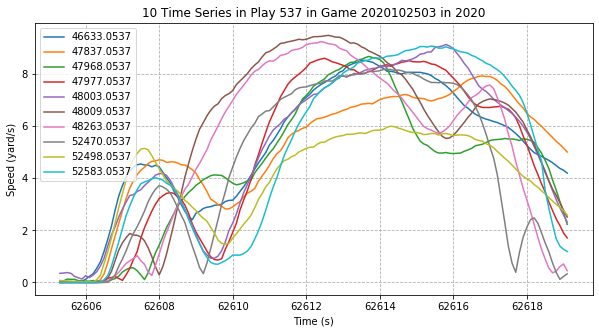

In [78]:
year = 2020
plt.figure(figsize=(10, 5))
for i in range(100, 110):
    tsId = tracking_small[year].tsId.unique()[i]
    df1 = tracking_small[year][tracking_small[year].tsId == tsId].loc[:,['time', 's']]
    x = df1['time'].apply(time_transformation)
    plt.plot(x, df1.s, label=tsId)
    plt.legend()

plt.legend()
plt.title('10 Time Series in Play 537 in Game 2020102503 in 2020')
plt.xlabel('Time (s)')
plt.ylabel('Speed (yard/s)')
plt.grid(linestyle='--')

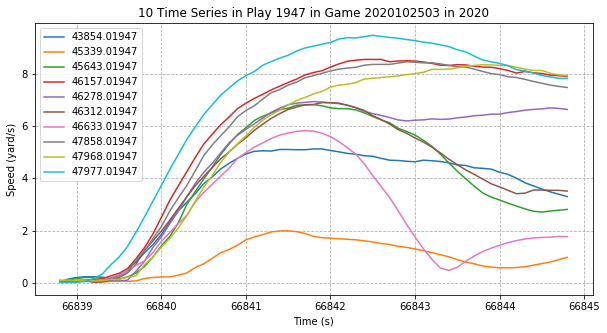

In [95]:
year = 2020
plt.figure(figsize=(10, 5))
for i in range(290, 300):
    tsId = tracking_small[year].tsId.unique()[i]
    df1 = tracking_small[year][tracking_small[year].tsId == tsId].loc[:,['time', 's']]
    x = df1['time'].apply(time_transformation)
    plt.plot(x, df1.s, label=tsId)
    plt.legend()

plt.legend()
plt.title('10 Time Series in Play 1947 in Game 2020102503 in 2020')
plt.xlabel('Time (s)')
plt.ylabel('Speed (yard/s)')
plt.grid(linestyle='--')

By observing these figures, we think that there is no seasonal trend in these series.

## Stationality Testing

- Given the time series $\mathbf{y}$.
- The null hypotheisis $H_0$: $\mathbf{y}$ is non-stationary.
- The alternate hypothesis $H_1$: $\mathbf{y}$ stationary.
- If the p value is less than 0.05, then we reject $H_0$.

### Create a function to report if the given time series is stationary or not

In [58]:
def adfuller_test(s, verbose=True):
    result = adfuller(s)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    if verbose:
        for value, label in zip(result, labels):
            print(label + ': ' + str(round(value, 4)))
    if result[1] < 0.05:
        stationary = True
        if verbose:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        stationary = False
        if verbose:
            print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
    return stationary

### Collect tsId of all stationary and non-stationary TS

In [47]:
dict_tsId = {}

for year in [2018, 2019, 2020]:
    dict_tsId[year] = {'stationary': [], 'non_stationary': []}
    
    for tsId in tqdm(tracking_small[year].tsId.unique()):
        df = tracking_small[year].loc[tracking_small[year].tsId == tsId, ['time', 's']]
        if adfuller_test(df['s'], verbose=False):
            dict_tsId[year]['stationary'].append(tsId)
        else:
            dict_tsId[year]['non_stationary'].append(tsId)

100%|██████████| 638/638 [00:04<00:00, 147.70it/s]


In [102]:
for year, d in dict_tsId.items():
    strings = 'In year %d, there are %d (%4.2f) stationary time series and %d non-stationary time series.'
    print(strings % (year, len(d['stationary']), len(d['stationary']) / len(d['stationary'] + d['non_stationary'])*100, len(d['non_stationary'])))

In year 2018, there are 257 (43.27) stationary time series and 337 non-stationary time series.
In year 2019, there are 138 (33.01) stationary time series and 280 non-stationary time series.
In year 2020, there are 290 (45.45) stationary time series and 348 non-stationary time series.


## Create ARIMA models for each stationary time series without differencing (`d=0`)

In [112]:
import warnings
warnings.filterwarnings("ignore")

In [114]:
dict_models = {}
fails = []

for year in [2018, 2019, 2020]:
    dict_models[year] = {}
    #dict_AICs[year] = {}
    
    for tsId in tqdm(dict_tsId[year]['stationary']):
        ts = tracking_small[year].loc[tracking_small[year].tsId == tsId, 's']
        try:
            model_fit = ARIMA(ts, order=(1, 0, 1)).fit()
        except:
            try:
                model_fit = ARIMA(ts, order=(2, 0, 1)).fit()
            except:
                try:
                    model_fit = ARIMA(ts, order=(2, 0, 2)).fit()
                except:
                    fails.append(tsId)
        dict_models[year][tsId] = model_fit

100%|██████████| 290/290 [00:19<00:00, 15.19it/s]


### Auto-ARIMA

In [303]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [370]:
dict_auto_models = {2018: {}, 2019: {}, 2020: {}}

t0 = time.time()
for year in [2018, 2019, 2020]:
    dict_models[year] = {}
    #dict_AICs[year] = {}
    
    for tsId in tqdm(dict_tsId[year]['stationary']):
        ts = tracking_small[year].loc[tracking_small[year].tsId == tsId, 's']
        smodel = pm.auto_arima(
            ts, start_p=1, start_q=1, max_D=0, test='adf', max_p=3, max_q=3, d=None,
            seasonal=False, start_P=0, D=0, trace=False, error_action='ignore',  
            suppress_warnings=True, stepwise=False)
        dict_auto_models[year][tsId] = smodel
print('Time cost: %8.2f' % (time.time() - t0))

100%|██████████| 290/290 [11:01<00:00,  2.28s/it]

Time cost:  1831.40


In [333]:
with open('./dict_auto_models.pkl', 'wb') as f:
    pickle.dump(dict_auto_models, f, pickle.HIGHEST_PROTOCOL)

In [361]:
dict_p, dict_q, dict_model2, dict_aic_, dict_mae_, dict_rmse_ = {}, {}, {}, {}, {}, {}
error = []

for y in dict_tsId.keys():
    dict_p[y] = []
    dict_q[y] = []
    dict_model2[y] = []
    dict_aic_[y] = []
    dict_mae_[y] = []
    dict_rmse_[y] = []
    
    for tsId in tqdm(dict_tsId[y]['stationary']):
        smodel = dict_auto_models[y][tsId]
        
        df_ = pd.DataFrame()
        df_['Speed'] = tracking_small[y].loc[tracking_small[y].tsId == tsId, 's']
        
        p = smodel.get_params()['order'][0]
        q = smodel.get_params()['order'][2]
        try:
            model = ARIMA(df_['Speed'], order=(p, 0, q)).fit()
            df_['Forecasted Speed'] = model.predict(start=int(L*.7), end=L-1, dynamic=True)
            S = pd.isnull(df_['Forecasted Speed'])
            mae = mean_absolute_error(df_.loc[-S, 'Speed'], df_.loc[-S, 'Forecasted Speed'])
            rmse = mean_squared_error(df_.loc[-S, 'Speed'], df_.loc[-S, 'Forecasted Speed'])**.5
        except:
            error.append(tsId)
            
        dict_p[y].append(p)
        dict_q[y].append(q)
        dict_model2[y].append(model)
        dict_aic_[y].append(smodel.aic())
        dict_mae_[y].append(mae)
        dict_rmse_[y].append(rmse)

100%|██████████| 290/290 [01:01<00:00,  4.75it/s]


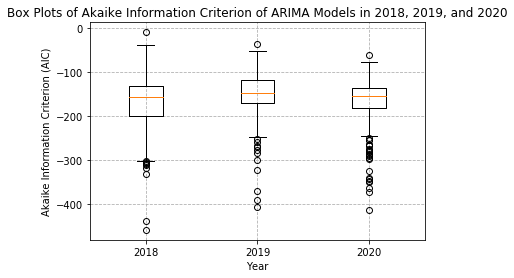

In [364]:
plt.boxplot([v for k, v in dict_aic_.items()])
plt.title('Box Plots of Akaike Information Criterion of ARIMA Models in 2018, 2019, and 2020')
plt.xlabel('Year')
plt.ylabel('Akaike Information Criterion (AIC)')
plt.xticks([1, 2, 3], labels=[2018, 2019, 2020])
plt.grid(linestyle='--')
plt.show()

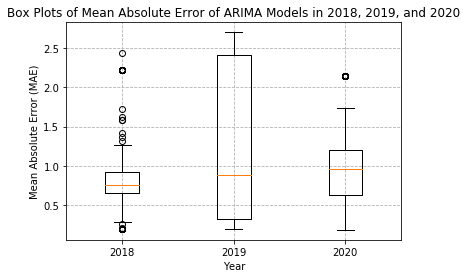

In [362]:
plt.boxplot([v for k, v in dict_mae_.items()])
plt.title('Box Plots of Mean Absolute Error of ARIMA Models in 2018, 2019, and 2020')
plt.xlabel('Year')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks([1, 2, 3], labels=[2018, 2019, 2020])
plt.grid(linestyle='--')
plt.show()

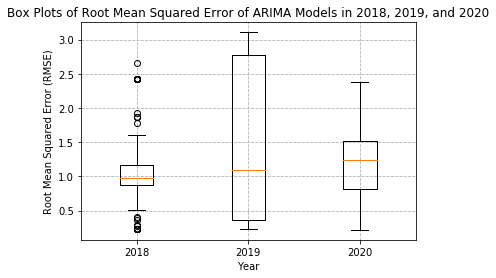

In [363]:
plt.boxplot([v for k, v in dict_rmse_.items()])
plt.title('Box Plots of Root Mean Squared Error of ARIMA Models in 2018, 2019, and 2020')
plt.xlabel('Year')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks([1, 2, 3], labels=[2018, 2019, 2020])
plt.grid(linestyle='--')
plt.show()

In [290]:
dict_mae, dict_rmse = {}, {}
error = []

for y, d in dict_models.items():
    dict_mae[y] = []
    dict_rmse[y] = []
    for tsId, model in tqdm(dict_models[y].items()):
        df_ = pd.DataFrame()
        df_['Speed'] = tracking_small[y].loc[tracking_small[y].tsId == tsId, 's']
        L = df_.shape[0]
        df_['Forecasted Speed'] = model.predict(start=int(L*.7), end=L-1, dynamic=True)
        S = pd.isnull(df_['Forecasted Speed'])
        try:
            mae = mean_absolute_error(df_.loc[-S, 'Speed'], df_.loc[-S, 'Forecasted Speed'])
            rmse = mean_squared_error(df_.loc[-S, 'Speed'], df_.loc[-S, 'Forecasted Speed'])**.5
        except:
            error.append(tsId)
        dict_mae[y].append(mae)
        dict_rmse[y].append(rmse)

100%|██████████| 290/290 [00:01<00:00, 186.07it/s]


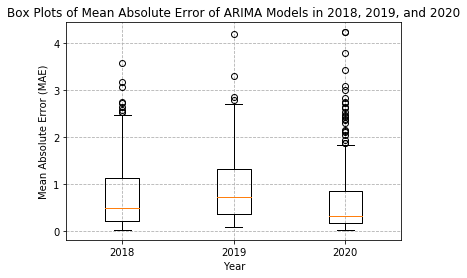

In [295]:
plt.boxplot([v for k, v in dict_mae.items()])
plt.title('Box Plots of Mean Absolute Error of ARIMA Models in 2018, 2019, and 2020')
plt.xlabel('Year')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks([1, 2, 3], labels=[2018, 2019, 2020])
plt.grid(linestyle='--')
plt.show()

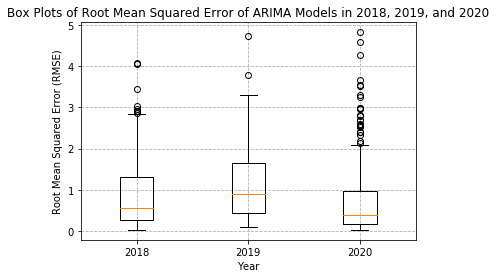

In [296]:
plt.boxplot([v for k, v in dict_rmse.items()])
plt.title('Box Plots of Root Mean Squared Error of ARIMA Models in 2018, 2019, and 2020')
plt.xlabel('Year')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks([1, 2, 3], labels=[2018, 2019, 2020])
plt.grid(linestyle='--')
plt.show()

In [292]:
tracking_small[y].loc[tracking_small[y].tsId == '37267.03318', 's']

Series([], Name: s, dtype: float64)

In [175]:
dict_tsId[2018].keys()

dict_keys(['stationary', 'non_stationary'])

In [176]:
dict_ts_lengths = {}

for year in [2018, 2019, 2020]:
    dict_ts_lengths[year] = [] 
    for tsId in tqdm(dict_tsId[year]['stationary']):
        dict_ts_lengths[year].append(sum(tracking_small[year].tsId == tsId))
    for tsId in tqdm(dict_tsId[year]['non_stationary']):
        dict_ts_lengths[year].append(sum(tracking_small[year].tsId == tsId))

100%|██████████| 348/348 [00:01<00:00, 188.67it/s]


In [297]:
dict_tsId.keys()

dict_keys([2018, 2019, 2020])

In [299]:
dict_tsId[2018].keys()

dict_keys(['stationary', 'non_stationary'])

In [301]:
len(dict_tsId[2018]['stationary'])

257

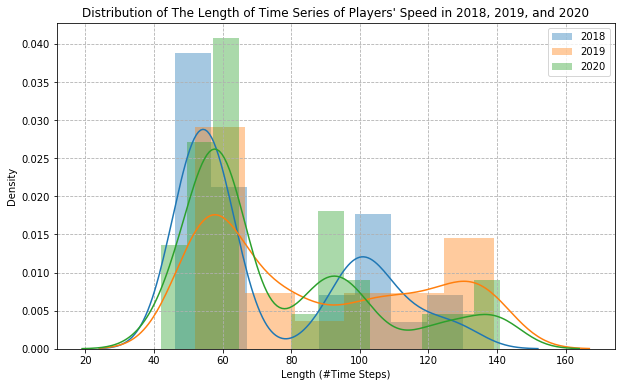

In [177]:
plt.figure(figsize=(10, 6))
for k, v in dict_ts_lengths.items():
    sns.distplot(v, label=k)
plt.title("Distribution of The Length of Time Series of Players' Speed in 2018, 2019, and 2020")
plt.xlabel('Length (#Time Steps)')
plt.grid(linestyle='--')
plt.legend()
plt.show()

In [178]:
dict_ts_lengths_stationary = {}

for year in [2018, 2019, 2020]:
    dict_ts_lengths_stationary[year] = [] 
    for tsId in tqdm(dict_tsId[year]['stationary']):
        dict_ts_lengths_stationary[year].append(sum(tracking_small[year].tsId == tsId))

100%|██████████| 290/290 [00:01<00:00, 186.98it/s]


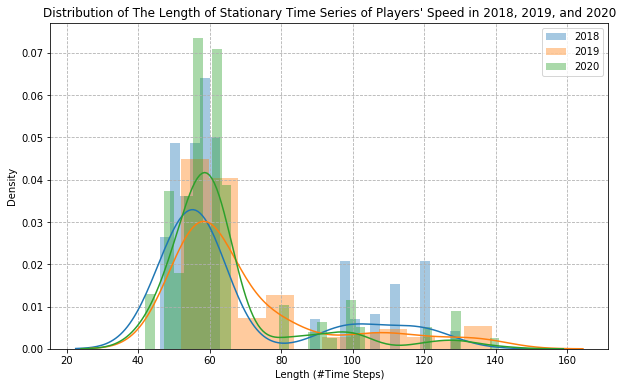

In [180]:
plt.figure(figsize=(10, 6))
for k, v in dict_ts_lengths_stationary.items():
    sns.distplot(v, label=k)
plt.title("Distribution of The Length of Stationary Time Series of Players' Speed in 2018, 2019, and 2020")
plt.xlabel('Length (#Time Steps)')
plt.grid(linestyle='--')
plt.legend()
plt.show()

In [117]:
for k, v in dict_models.items():
    print(k, len(v))
print(len(fails))

2018 257
2019 138
2020 290
1


In [118]:
fails

['37267.03318']

In [121]:
model_fit.aic

-49.15320138289388

In [122]:
model_fit.k_ar

1

In [123]:
model_fit.k_ma

1

In [130]:
dict_p = {2018: {}, 2019: {}, 2020: {}}
dict_q = {2018: {}, 2019: {}, 2020: {}}
dict_aic = {2018: {}, 2019: {}, 2020: {}}
dict_mae = {2018: {}, 2019: {}, 2020: {}}
dict_rmse = {2018: {}, 2019: {}, 2020: {}}

for year in [2018, 2019, 2020]:
    for k, v in tqdm(dict_models[year].items()):
        playId = int(k.split('.0')[-1])
        if playId not in dict_p[year].keys():
            dict_p[year][playId] = []
            dict_q[year][playId] = []
            dict_aic[year][playId] = []
        dict_p[year][playId].append(v.k_ar)
        dict_q[year][playId].append(v.k_ma)
        dict_aic[year][playId].append(v.aic)

100%|██████████| 290/290 [00:00<00:00, 89384.79it/s]


In [146]:
dict_aic__ = {}
for year in [2018, 2019, 2020]:
    dict_aic__[year] = []
    for v in dict_aic[year].values():
        dict_aic__[year] += v

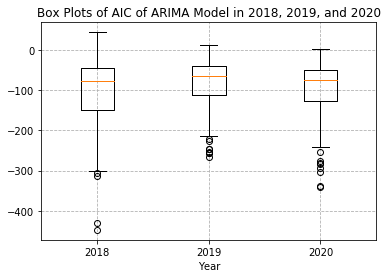

In [158]:
plt.boxplot([v for k, v in dict_aic__.items()])
plt.title('Box Plots of AIC of ARIMA Model in 2018, 2019, and 2020')
plt.xlabel('Year')
plt.xticks([1, 2, 3], labels=[2018, 2019, 2020])
plt.grid(linestyle='--')
plt.show()

## Differencing

The data is already stationary so that we don't need to do differencing. Which means d=0.

In [26]:
#tracking_small[2018].tsId.unique()[4]
#df = tracking_small[2018][tracking_small[2018].tsId == tsId].loc[:,['time', 's']]
#df['S First Difference'] = df['s'] - df['s'].shift(10)

In [27]:
#test again
#become stationary!
#adfuller_test(df['S First Difference'].dropna()) 

In [28]:
#following code is teacher's code for "Seasonal",this data is not composed of 12 months
#df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)
#adfuller_test(df['Seasonal First Difference'].dropna())
#df['Seasonal First Difference'].plot()

In [29]:
#df['s'].plot()

# Auto Regressive Model


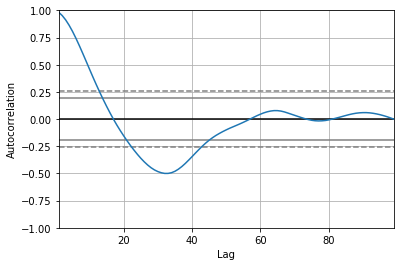

In [28]:
#If BETA is closer to 1, means at the time, the correlatoion is high, and level of fluctuation range is not that much.

autocorrelation_plot(df['s'])
plt.show()

# Final Thoughts on Autocorrelation and Partial Autocorrelation
Identification of an AR model is often best done with the PACF.
For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q p AR model lags d differencing q MA lags

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [30]:
df['s']

9334866    0.24
9334867    0.24
9334868    0.25
9334869    0.22
9334870    0.19
           ... 
9334960    1.84
9334961    1.59
9334962    1.39
9334963    1.19
9334964    1.03
Name: s, Length: 99, dtype: float64

/home/jayliao2/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


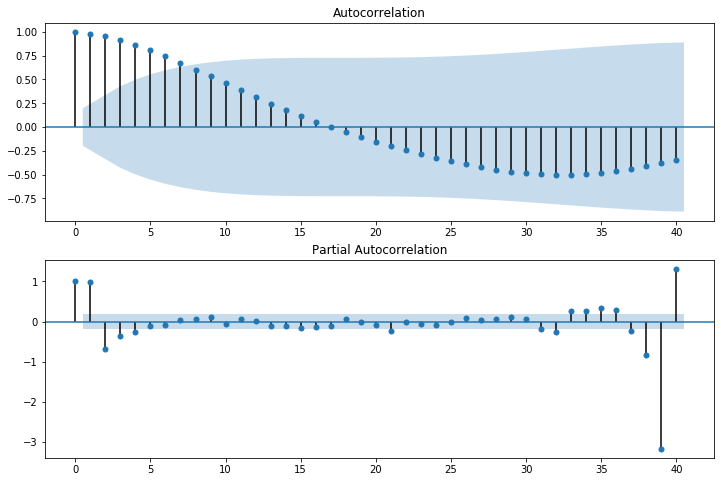

In [31]:
#the method to find the p=2,q=2
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['s'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['s'],lags=40,ax=ax2)

In [32]:
#the method to find the p,q 
#fig = plt.figure(figsize=(12,8))
#ax1 = fig.add_subplot(211)
#fig = sm.graphics.tsa.plot_acf(df['S First Difference'].iloc[10:],lags=40,ax=ax1)
#ax2 = fig.add_subplot(212)
#fig = sm.graphics.tsa.plot_pacf(df['S First Difference'].iloc[10:],lags=40,ax=ax2)

In [33]:
# For non-seasonal data
#p=1, d=10, q=1

In [266]:
i = 0
year = 2019
tsId = tracking_small[year].tsId.unique()[i]
df1 = tracking_small[year][tracking_small[year].tsId == tsId].loc[:,['time', 's']]

In [267]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)

In [268]:
model = ARIMA(df1['s'], order=(2, 0, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      s   No. Observations:                   61
Model:                     ARMA(2, 1)   Log Likelihood                  51.609
Method:                       css-mle   S.D. of innovations              0.098
Date:                Thu, 02 Dec 2021   AIC                            -93.217
Time:                        21:09:02   BIC                            -82.663
Sample:                             0   HQIC                           -89.081
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5968      0.402      3.974      0.000       0.809       2.384
ar.L1.s        1.8062      0.069     26.051      0.000       1.670       1.942
ar.L2.s       -0.8443      0.070    -12.115      0.000      -0.981      -0.708
ma.L1.s        0.2745      0.126      2.179      0.029       0.028       0.521
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0696           -0.2009j            1.0883           -0.0295
AR.2            1.0696           +0.2009j            1.0883            0.0295
MA.1           -3.6435           +0.0000j            3.6435            0.5000
-----------------------------------------------------------------------------
"""

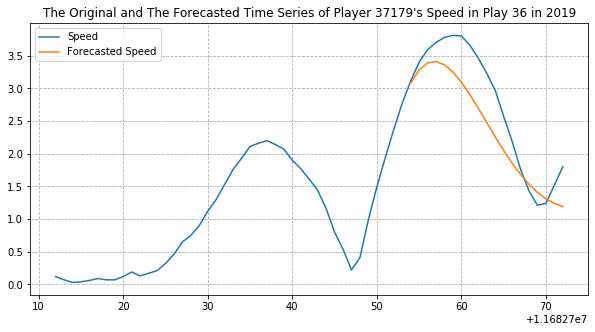

In [273]:
player = tsId.split('.0')[0]
play = tsId.split('.0')[-1]
L = df1.shape[0]
df1['Speed'] = df1['s']
df1['Forecasted Speed'] = model_fit.predict(start=int(L*.7), end=L-1, dynamic=True)
df1[['Speed','Forecasted Speed']].plot(figsize=(10, 5))
plt.grid(linestyle='--')
plt.title('The Original and The Forecasted Time Series of Player ' + player + "'s Speed in Play " + play + ' in ' + str(year))
plt.show()

In [41]:
model_fit.predict(start=99, end=120, dynamic=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


99     0.895204
100    0.790689
101    0.714617
102    0.666036
103    0.643735
104    0.646278
105    0.672030
106    0.719192
107    0.785836
108    0.869926
109    0.969360
110    1.081990
111    1.205654
112    1.338203
113    1.477521
114    1.621550
115    1.768313
116    1.915926
117    2.062618
118    2.206742
119    2.346789
120    2.481393
dtype: float64

In [42]:
df

,time,s,s_hat
9334866,2018-10-07T17:02:34.900,0.24,NaN
9334867,2018-10-07T17:02:35.000,0.24,NaN
9334868,2018-10-07T17:02:35.100,0.25,NaN
9334869,2018-10-07T17:02:35.200,0.22,NaN
9334870,2018-10-07T17:02:35.300,0.19,NaN
...,...,...,...
9334960,2018-10-07T17:02:44.300,1.84,3.600098
9334961,2018-10-07T17:02:44.400,1.59,3.594892
9334962,2018-10-07T17:02:44.500,1.39,3.579110
9334963,2018-10-07T17:02:44.600,1.19,3.553618


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


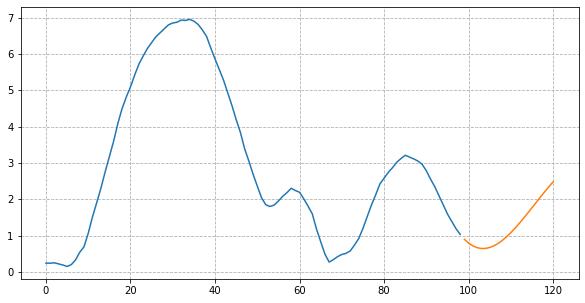

In [43]:
#df_future = pd.concat([df, ])
s_hat = model_fit.predict(start=99, end=120, dynamic=True)
plt.figure(figsize=(10, 5))
plt.plot(list(df['s']))
plt.plot(s_hat)
plt.grid(linestyle='--')